In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import fasttext
from sklearn import cluster
import re
import string

In [88]:
data_loc = '/home/cherepaha/Projects/made/3sem/realtime_news/news_data/'
news_path = os.path.join(data_loc, 'social_network_news.csv')
stats_path = os.path.join(data_loc, 'social_network_stats.csv')
rss_path = os.path.join(data_loc, 'news.csv')

In [89]:
news = pd.read_csv(news_path)
stats = pd.read_csv(stats_path)
rss = pd.read_csv(rss_path)

In [4]:
news.head()

,id,post_id,text,date,time,comments,likes,reposts,views,link,source_name,social_network
0,1885214,17828455,В какой-то момент учёные начали сомневаться в ...,2021-12-18,2021-12-18 11:01:05.000000,2,9,2.0,3780.0,{https://life.ru/p/1457797},life.ru,vk
1,1033381,30621,Цена газа в Европе уже превысила 1400 долларов...,2021-12-14,2021-12-14 07:20:20.000000,0,0,0.0,10.0,{https://1prime.ru/gas/20211214/835500297.html},1prime.ru,vk
2,424396,920132,Женская индивидуальная гонка свободным стилем ...,2021-12-12,2021-12-12 14:41:02.000000,0,1,0.0,246.0,{},www.mk.ru,vk
3,525,1417279,Американский Институт цвета Pantone назвал нов...,2021-12-09,2021-12-09 12:44:52.000000,0,0,1.0,180.0,{},rg.ru,vk
4,528,816441,«Генерал Мороз» и Миллер могут оставить Европу...,2021-12-09,2021-12-09 12:44:26.000000,0,0,0.0,42.0,{https://svpressa.ru/economy/article/318635/el...,svpressa.ru,vk


In [5]:
stats.head()

,id,post_id,comments,likes,reposts,views,social_network
0,1097477,1053052,2,2,3.0,1110.0,vk
1,1097482,1053029,0,8,0.0,1286.0,vk
2,1097516,1052901,0,14,0.0,2099.0,vk
3,1097521,1052881,6,5,1.0,1633.0,vk
4,1097525,1052866,7,6,3.0,2266.0,vk


In [6]:
stat_fields = ['comments', 'likes', 'reposts', 'views']
group_stats = stats.groupby(['post_id', 'social_network']).agg(
    **{f'{field}_max': (field, max) for field in stat_fields},
    **{f'{field}_min': (field, min) for field in stat_fields}
)

In [7]:
group_stats.head()

,,comments_max,likes_max,reposts_max,views_max,comments_min,likes_min,reposts_min,views_min
post_id,social_network,,,,,,,,
228,vk,0,2,1.0,48.0,0,0,0.0,0.0
229,vk,0,1,0.0,20.0,0,0,0.0,1.0
230,vk,0,0,0.0,8.0,0,0,0.0,1.0
1591,vk,2,5,0.0,750.0,2,5,0.0,748.0
1593,vk,0,4,1.0,635.0,0,4,1.0,621.0


# Per post visualization

In [8]:
post_id = 2573845
sn = 'vk'
post_dynamic = stats[(stats.post_id == post_id) & (stats.social_network == sn)]

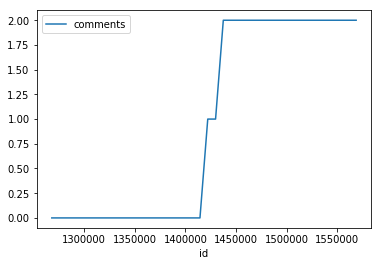

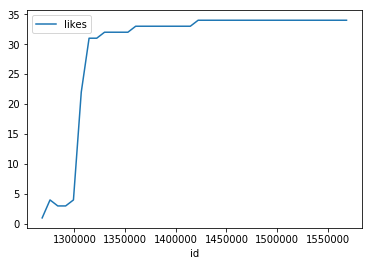

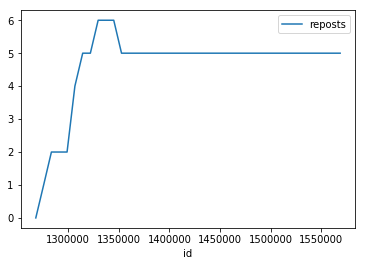

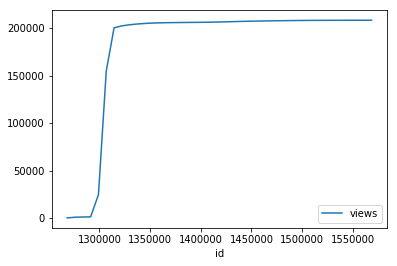

In [9]:
for f in stat_fields:
    post_dynamic.plot('id', f)

# Resource agg

Графики по какому-то домену: распределения лайков, вьюшек, в каком канале (вк или тг), средние по дням и т.п..

In [10]:
resource_stats = stats.merge(news[['source_name', 'post_id', 'date']], on='post_id', how='inner')
resource_stats = resource_stats.sort_values(stat_fields, ascending=False)
resource_stats.drop_duplicates('post_id', inplace=True)

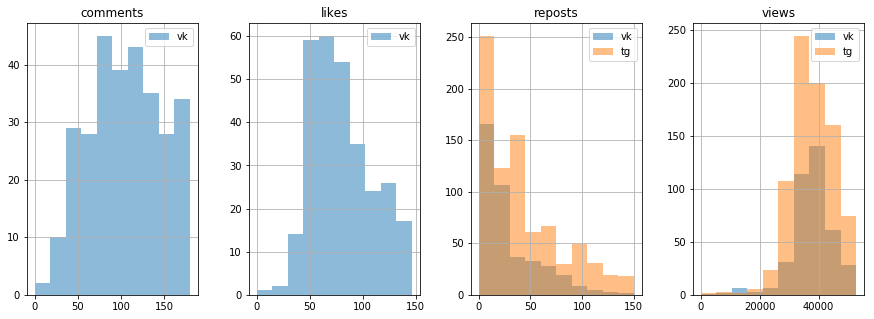

In [11]:
domain = 'ria.ru'
# domain = 'svpressa.ru'
domain_stats = resource_stats[resource_stats.source_name == domain]
plt.figure(figsize=(15, 5))
for i, f in enumerate(stat_fields):
    ax = plt.subplot(1, len(stat_fields), i + 1)
    
    left = 0
    right = domain_stats[f].quantile(0.9)
    plt_kwargs = dict(
        ax=ax,
        bins=10,
        alpha=0.5,
        range=(left, right)
    )
    
    domain_stats[domain_stats.social_network == 'vk'].hist(f, **plt_kwargs, label='vk')
    if domain_stats[domain_stats.social_network == 'tg'][f].sum():
        domain_stats[domain_stats.social_network == 'tg'].hist(f, **plt_kwargs, label='tg')
    plt.legend()

In [12]:
date_dynamic = resource_stats.groupby(['social_network', 'source_name', 'date']).agg(**{f: (f, sum) for f in stat_fields})
date_dynamic = date_dynamic.reset_index()

П.С. тут думал сделать сравнение между доменами, но их много и график получается нечитабельным

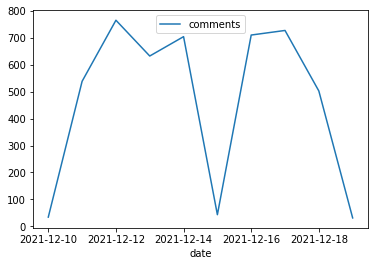

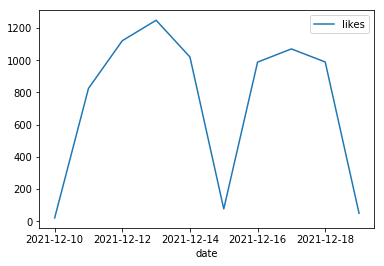

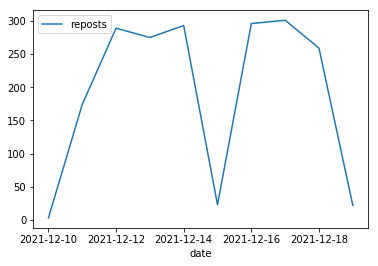

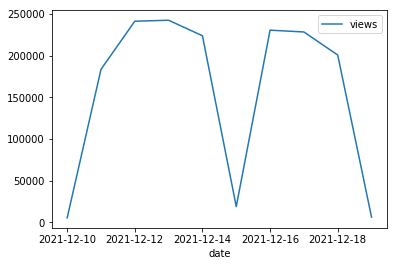

In [13]:
social_network = 'vk'
domain = 'iz.ru'

for f in stat_fields:
    data_filter = (date_dynamic['social_network'] == social_network) & (date_dynamic['source_name'] == domain)
    date_dynamic[data_filter].plot('date', f)


# Clusterization

Идея: найти похожие новости и сравнить лайки, вьюшки и т.д.

In [14]:
model = fasttext.load_model('cc.ru.300.bin')

In [52]:
emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)

def prepare_text(text):
    text = re.sub(r'(https?://\S+)', ' ', text)
    text = re.sub(r'/\n', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(emoji_pattern, ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [71]:
date = '2021-12-18'
news_text = news[news.date == date][['post_id', 'text', 'social_network']]
news_text.dropna(inplace=True)
news_text.loc[:, 'text'] = news_text['text'].apply(prepare_text)
news_text = news_text[news_text.text.apply(len) > 1]
text_emb = news_text['text'].apply(lambda x: model[x])

In [72]:
text_emb = pd.DataFrame(text_emb.to_list(), )

In [73]:
%%time
text_clusters = cluster.AgglomerativeClustering(
    n_clusters=None,
    affinity='cosine',
    linkage='complete',
    distance_threshold=0.1,
).fit_predict(text_emb)

CPU times: user 311 ms, sys: 3.75 ms, total: 315 ms
Wall time: 314 ms


In [74]:
news_text['cluster'] = text_clusters

In [87]:
news_text[news_text.cluster == 16].values

array([[95969,
        'Россия рассчитывает что НАТО не удастся заболтать российские предложения по гарантиям безопасности заявил Грушко Заместитель министра иностранных дел РФ отметил также что Россия перейдет в режим создания контругроз если НАТО не примет предложения по гарантиям безопасности По словам Грушко в отношениях РФ и НАТО наступил момент истины предложения Москвы нацелены на то чтобы отойти от опасной черты Россия будет последовательно добиваться построения европейской безопасности по принципам сформулированным Москвой заявил он',
        'tg', 16],
       [4241027,
        'Россия перейдет в режим создания контругроз если НАТО не примет предложения по гарантиям безопасности заявил заместитель министра иностранных дел РФ Александр Грушко ',
        'vk', 16],
       [2635016,
        'Россия рассчитывает что Североатлантическому альянсу не удастся «заболтать» российские предложения по гарантиям безопасности заявил заместитель министра иностранных дел РФ Александр Грушко ',

Вывод: Нужна хорошая кластеризация (Можно еще попробовать knn)

# RSS join

Идея: подтягивать текст новости из вк/тг

In [100]:
def preproc_link(link_set):
    link_set = link_set[1:-1].split(',')
    return link_set

In [113]:
news_link = news[['link', 'text']].dropna(subset=['link'])

news_link.loc[:, 'link'] = news_link.link.apply(preproc_link)

news_link = news_link.explode('link')

news_link = news_link[news_link.link.apply(len) > 0]

In [121]:
rss_vk_merged = rss[['date', 'content', 'title', 'source_url', 'source_name']].merge(
    news_link,
    left_on='source_url',
    right_on='link'
)

In [124]:
rss_vk_merged.shape

(1716, 7)

In [125]:
rss.shape

(23173, 13)

Слишком маленькое пересечение